# **NOMAD OEM (Occlusion Estimation Module)**

---
The **Occlusion Estimation Module (OEM)** is implemented to systematically generate occlusion masks from annotated images. The process begins by accessing the dataset and annotation files, ensuring structured data retrieval. Image file paths are mapped to their corresponding annotations, facilitating efficient processing.

- For each image, a binary mask is initialized and occlusion regions are identified based on bounding box annotations. If necessary, YOLO-formatted relative coordinates are converted into absolute pixel values, ensuring accurate spatial representation.

- The occlusion level, derived from the visibility metric, is scaled to an intensity range between 1 and 255 and applied to the mask. The generated occlusion masks are stored for further analysis with periodic progress updates ensuring the efficiency of the process.

This automated pipeline enables a structured and reproducible approach to occlusion-aware data preprocessing, enhancing the robustness of occlusion estimation models.


Data Collection & Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/NOMAD" /content/

In [ ]:
!ls /content/NOMAD

annotations  images  labels


In [ ]:
!ls /content/NOMAD/images | head

Actor001
Actor002
Actor003
Actor004
Actor005
Actor006
Actor007
Actor008
Actor009
Actor010


In [ ]:
!ls /content/NOMAD/labels | head

Actor001
Actor002
Actor003
Actor004
Actor005
Actor006
Actor007
Actor008
Actor009
Actor010


In [ ]:
!ls /content/NOMAD/annotations | head

activityLabels.json
activityLabels_waterRoutine.json
annotations.json
metadata.json


In [ ]:
!ls /content/NOMAD/images/Actor001 | head

Actor001_a10
Actor001_a30
Actor001_a50
Actor001_a70
Actor001_a90


Annotation Structure

In [ ]:
import json

# Load the JSON file
annotations_path = "/content/NOMAD/annotations/annotations.json"  # Adjust path
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Print a small sample
print(json.dumps(annotations, indent=4)[:1000])  # Display first 1000 characters

[
    {
        "file_name": "Actor001_a10_f0001.jpg",
        "height": 3078,
        "width": 5472,
        "image_id": "Actor001_a10_f0001.jpg",
        "annotations": [
            {
                "bbox": [
                    1610.0,
                    1856.0,
                    182.0,
                    316.0
                ],
                "bbox_mode": 1,
                "category_id": 0,
                "iscrowd": 0,
                "visibility": "100"
            }
        ]
    },
    {
        "file_name": "Actor001_a10_f0114.jpg",
        "height": 3078,
        "width": 5472,
        "image_id": "Actor001_a10_f0114.jpg",
        "annotations": [
            {
                "bbox": [
                    2012.0,
                    1793.0,
                    141.0,
                    320.0
                ],
                "bbox_mode": 1,
                "category_id": 0,
                "iscrowd": 0,
                "visibility": "80"
            }
        ]
  

In [ ]:
metadata_path = "/content/NOMAD/annotations/metadata.json"
with open(metadata_path, "r") as f:
    metadata = json.load(f)

print(json.dumps(metadata, indent=4))

[
    {
        "id": 1,
        "environmental": {
            "date[MM-DD]": "06-20",
            "time[HH]": "12",
            "location": "Farm",
            "weather": {
                "temperature[F]": 83,
                "wind_speed[MPH]": 9,
                "descriptor": "Sunny"
            },
            "video": {
                "video_resolution": "5.4k",
                "fps": 30,
                "img_width": 5472,
                "img_height": 3078,
                "focal_lenght[mm]": 8
            },
            "ev[r,10,30,50,70,90]": "[0,0,0,0,0,0]"
        },
        "demographic": {
            "age": 61,
            "gender": "Female",
            "race": "White/Caucasian",
            "weight[lbs]": 145,
            "height[in]": 64,
            "facial_hair": {
                "beard": false,
                "mustache": false
            },
            "hair": {
                "lenght": "medium",
                "color": "sandy",
                "descriptor": "p

OEM Mask Creation

In [ ]:
import cv2
import numpy as np
import json
import os
from glob import glob
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
annotations_path = "/content/NOMAD/annotations/annotations.json"
image_root_folder = "/content/NOMAD/images"  # Root folder with all actor subfolders
drive_mask_folder = "/content/drive/MyDrive/NOMAD_OEM/"  # Save directly to Google Drive
os.makedirs(drive_mask_folder, exist_ok=True)  # Ensure directory exists

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Build a mapping of image file names to full paths (since images are in subfolders)
image_paths = {os.path.basename(p): p for p in glob(os.path.join(image_root_folder, "**", "*.jpg"), recursive=True)}

# Process images one by one
for idx, entry in enumerate(annotations):
    file_name = entry["file_name"]
    img_path = image_paths.get(file_name, None)  # Get full path

    if img_path is None:
        print(f"⚠️ Image not found: {file_name}")
        continue  # Skip if image is missing

    # Define the mask path
    mask_path = os.path.join(drive_mask_folder, file_name.replace(".jpg", "_mask.png"))

    # Skip if the mask already exists (prevents reprocessing)
    if os.path.exists(mask_path):
        print(f"⏩ Skipping {file_name}, mask already exists.")
        continue

    # Load image
    image = cv2.imread(img_path)
    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)  # Blank mask

    # Process bounding boxes
    for ann in entry["annotations"]:
        if "bbox" not in ann or "visibility" not in ann:
            continue  # Skip malformed annotations

        bbox = list(map(float, ann["bbox"]))

        if len(bbox) != 4:
            print(f"⚠️ Skipping malformed bbox: {bbox} in {file_name}")
            continue

        x_center, y_center, w, h = bbox

        # Check if values are in absolute format
        if x_center > 1.5 and y_center > 1.5:  # Already in pixel values
            x, y = int(x_center), int(y_center)
            w, h = int(w), int(h)
        else:  # Convert YOLO relative format
            x_center, y_center, w, h = (
                int(x_center * width),
                int(y_center * height),
                int(w * width),
                int(h * height),
            )
            x = x_center - w // 2
            y = y_center - h // 2

        # Clamp bounding box within image boundaries
        x = max(0, min(x, width - 1))
        y = max(0, min(y, height - 1))
        w = max(1, min(w, width - x))
        h = max(1, min(h, height - y))

        # Compute occlusion value
        visibility = max(0, min(100, int(ann["visibility"])))  # Clamp to [0, 100]
        occlusion_value = max(1, int((visibility / 100) * 255))  # Ensure min value of 1

        # Draw occlusion mask
        cv2.rectangle(mask, (x, y), (x + w, y + h), occlusion_value, thickness=-1)

    # Save occlusion mask to Google Drive (only if it's newly generated)
    cv2.imwrite(mask_path, mask)

    # Print progress every 50 images
    if idx % 50 == 0:
        print(f"✅ Processed {idx} images...")

print("🎯 All OEM masks are being saved directly to Google Drive!")


Streaming output truncated to the last 5000 lines.
⏩ Skipping Actor088_a70_f1310.jpg, mask already exists.
⏩ Skipping Actor088_a70_f1322.jpg, mask already exists.
⏩ Skipping Actor088_a70_f1336.jpg, mask already exists.
⏩ Skipping Actor088_a70_f1350.jpg, mask already exists.
⏩ Skipping Actor088_a70_f1370.jpg, mask already exists.
⏩ Skipping Actor088_a70_f1390.jpg, mask already exists.
⏩ Skipping Actor088_a70_f1740.jpg, mask already exists.
⏩ Skipping Actor088_a70_f1830.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2130.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2139.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2157.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2175.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2184.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2193.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2202.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2208.jpg, mask already exists.
⏩ Skipping Actor088_a70_f2262.jpg, mask already exist

In [ ]:
for ann in entry["annotations"]:
    print(f"File: {file_name} - Visibility: {ann['visibility']}")

File: Actor001_a30_f0744.jpg - Visibility: 60


In [ ]:
for ann in entry["annotations"]:
    if "bbox" not in ann or "visibility" not in ann:
        continue  # Skip malformed annotations

    x_center, y_center, w, h = ann["bbox"]  # YOLO format (relative)

    # Convert relative to absolute pixel values
    x_center, y_center, w, h = (
        int(x_center * width),
        int(y_center * height),
        int(w * width),
        int(h * height),
    )

    # Convert center to top-left corner
    x = max(0, x_center - w // 2)
    y = max(0, y_center - h // 2)

    # Debugging outputs
    print(f"File: {file_name} - BBox: {x, y, w, h} - Visibility: {ann['visibility']}")

    # Ensure bounding box is valid
    if w <= 0 or h <= 0:
        print(f"⚠️ Skipping invalid bbox: {ann['bbox']} in {file_name}")
        continue

File: Actor001_a30_f0744.jpg - BBox: (15877008, 7028613, 487008, 175446) - Visibility: 60


In [ ]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
local_mask_folder = "/content/NOMAD/occlusion_masks"
drive_mask_folder = "/content/drive/MyDrive/NOMAD_OEM/"

# Create the folder in Google Drive if it doesn't exist
os.makedirs(drive_mask_folder, exist_ok=True)

# Copy all masks to Google Drive
for mask_file in os.listdir(local_mask_folder):
    src = os.path.join(local_mask_folder, mask_file)
    dst = os.path.join(drive_mask_folder, mask_file)
    shutil.copy(src, dst)

print(f"✅ All OEM masks saved to Google Drive at: {drive_mask_folder}")

Visualizing the OEMs

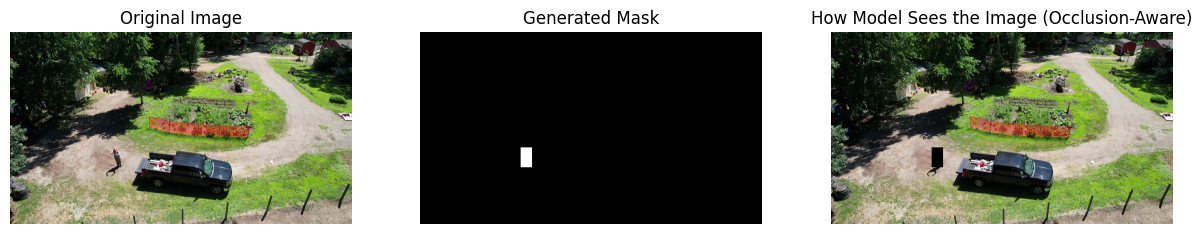

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths
original_image_path = "/content/drive/MyDrive/NOMAD/images/Actor001/Actor001_a10/Actor001_a10_f0001.jpg"
mask_path = "/content/drive/MyDrive/NOMAD_OEM/Actor001_a10_f0001_mask.png"

# Load original image
original_image = cv2.imread(original_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization

# Load mask in grayscale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Ensure mask is loaded correctly
if mask is None:
    raise FileNotFoundError(f"Mask file not found or unreadable: {mask_path}")

# Normalize mask for blending (convert range 0-255 to 0-1)
mask_normalized = mask.astype(np.float32) / 255.0

# Blend image and mask (higher occlusion = darker area)
overlay = (original_image * (1 - mask_normalized[:, :, None])).astype(np.uint8)

# Plot original, mask, and blended image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Generated Mask")
axes[2].imshow(overlay)
axes[2].set_title("How Model Sees the Image (Occlusion-Aware)")

for ax in axes:
    ax.axis("off")

plt.show()